In [148]:
import numpy as np
import fitsio
from astropy.table import Table, join
import os
from matplotlib import pyplot as plt
from desitarget.targetmask import zwarn_mask
from desitarget import targetmask
from scipy.special import erf

In [4]:
fe = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-main-dark-cumulative.fits')

In [2]:
oc = Table.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/everest/specobscon_dark.fits')
#

In [3]:
oc['TILEID'] = oc['TILEID'].astype(int)

In [160]:
print(len(oc),len(fe))

1498500 1498500


In [5]:
fe = join(fe,oc,keys=['TARGETID','LOCATION','TILEID'], uniq_col_name='{col_name}{table_name}', table_names=['', 'oc'])
print(len(fe))
fe.dtype.names

1498500


('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'COADD_FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MASKBITS',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'BRICKNAME',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET',
 'SCND_TARGET',
 'PLAT

In [7]:
sel = fe['DESI_TARGET'] & targetmask.desi_mask['LRG'] > 0
print(len(fe),len(fe[sel]))

1498500 346063


In [8]:
sel &= fe['COADD_FIBERSTATUS'] == 0
fl = fe[sel]
print(len(fl))

340944


In [9]:
#redshift success criteria from Rongpu
drz = (10**(3 - 3.5*fl['Z']))
mask_bad = (drz>30) & (fl['DELTACHI2']<30)
mask_bad |= (drz<30) & (fl['DELTACHI2']<drz)
mask_bad |= (fl['DELTACHI2']<10)
wz = fl['ZWARN'] == 0
wz &= fl['Z']<1.4
wz &= (~mask_bad)


In [10]:
#set minimum/maximum TSNR2_LRG for the rest of the plots
mint = 70
maxt = 120


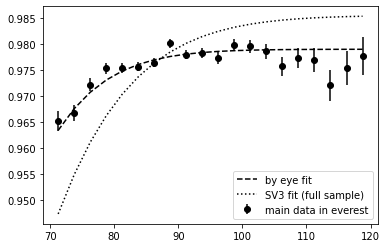

In [11]:
#look at overall z success
ntot,tb = np.histogram(fl['TSNR2_LRG'],bins=20,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr

plt.errorbar(bl,ng/ntot,el,fmt='ko',label='main data in everest')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label='by eye fit')
em3 = erf((bl-13.2)/39.7)*.9855
plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend()
plt.show()

(array([4.0100e+02, 2.2132e+04, 6.6914e+04, 9.7162e+04, 8.7824e+04,
        4.9157e+04, 1.4708e+04, 2.4120e+03, 1.6000e+02, 3.0000e+00]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ],
       dtype=float32),
 <a list of 10 Patch objects>)

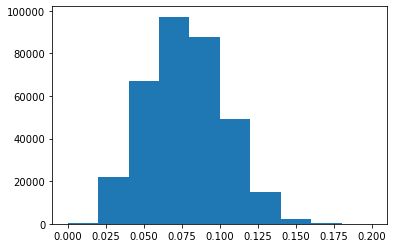

In [12]:
speed = fl['TSNR2_LRG']/fl['COADD_EXPTIME']
plt.hist(speed,range=(0,.2))

In [13]:
mds = np.median(speed)

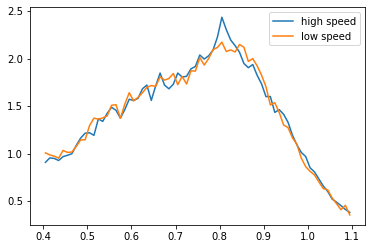

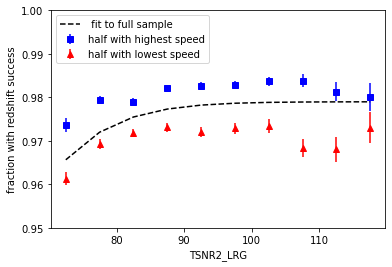

In [14]:
#split on speed
speedc = speed > mds
ntot,tb = np.histogram(fl[speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzh,zb = np.histogram(fl[speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
nl,_ = np.histogram(fl[~speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzl,_ = np.histogram(fl[~speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
stepz =zb[1]-zb[0]
zl = zb[:-1]+stepz/2.
plt.plot(zl,nzh,label='high speed')
plt.plot(zl,nzl,label='low speed')
plt.legend()
plt.show()
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest speed')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest speed')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.95,1.0)
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction with redshift success')
plt.show()

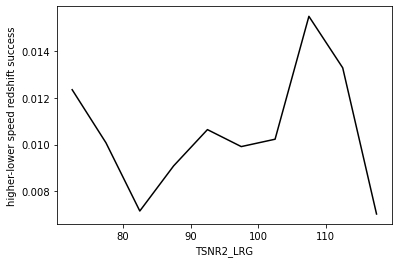

In [105]:
plt.plot(bl,ng/ntot-ngl/nl,'k-')
plt.xlabel('TSNR2_LRG')
plt.ylabel('higher-lower speed redshift success')
plt.show()

(array([53204., 98365., 95566., 48595., 23301., 11785.,  6038.,  2542.,
         1041.,   401.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ],
       dtype=float32),
 <a list of 10 Patch objects>)

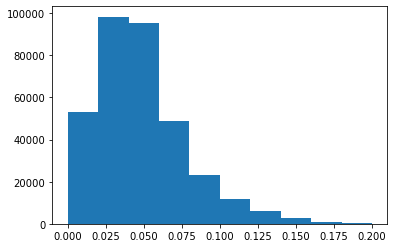

In [46]:
plt.hist(fl['EBV'],range=(0,.2))

In [15]:
ebm = np.median(fl['EBV'])
print(ebm)


0.043260083


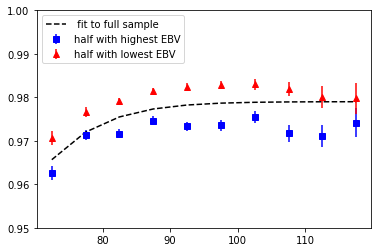

In [16]:
#split on EBV
speedc = fl['EBV'] > ebm
ntot,tb = np.histogram(fl[speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nl,_ = np.histogram(fl[~speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest EBV')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest EBV')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.95,1.0)
plt.show()


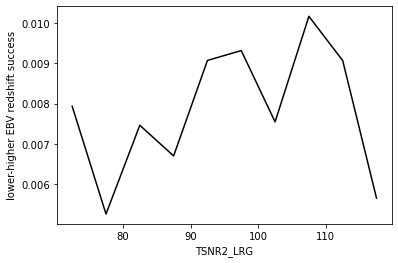

In [108]:
plt.plot(bl,ngl/nl-ng/ntot,'k-')
plt.xlabel('TSNR2_LRG')
plt.ylabel('lower-higher EBV redshift success')
plt.show()

### difference in success with EBV split pretty consistent with TSNR2, look at success rate vs EBV for high TSNR2

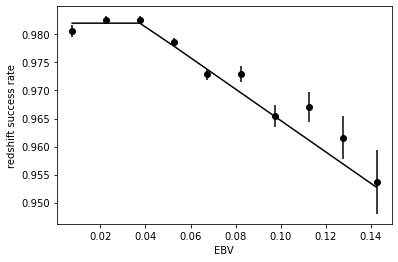

In [19]:
selht = fl['TSNR2_LRG'] > 85
ntot,tb = np.histogram(fl[selht]['EBV'],bins=10,range=(0,0.15))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[selht&gz]['EBV'],bins=tb)
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
modl = np.zeros(len(bl))
for ii in range(0,len(bl)):
    modl[ii] = ebvmod(bl[ii])
plt.errorbar(bl,ng/ntot,el,fmt='ko')
plt.plot(bl,modl,'k-')
plt.ylabel('redshift success rate')
plt.xlabel('EBV')
plt.show()


In [18]:
#fiducial parameters are just bye eye fit to above plot
#would have been more convenient if written in format that can handle arrays, but...
def ebvmod(ebv,base=.982,m=-.28):
    spl = 0.038
    if ebv < spl:
        return base
    else:
        b = base-spl*m
        return b+m*ebv

In [20]:
#make list of weights to account for EBV trend
ewl = np.zeros(len(fl))
ebvl = fl['EBV']
for ii in range(0,len(ewl)):
    ewl[ii] = .982/ebvmod(ebvl[ii])

In [38]:
len(fl),len(ewl)

(340944, 340944)

(array([2.41785e+05, 5.18420e+04, 2.42410e+04, 1.22820e+04, 6.23400e+03,
        2.80000e+03, 1.13600e+03, 4.62000e+02, 1.33000e+02, 2.90000e+01]),
 array([1.        , 1.00586959, 1.01173917, 1.01760876, 1.02347835,
        1.02934794, 1.03521752, 1.04108711, 1.0469567 , 1.05282628,
        1.05869587]),
 <a list of 10 Patch objects>)

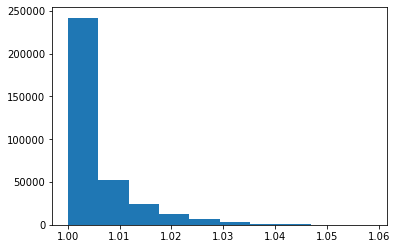

In [114]:
plt.hist(ewl)

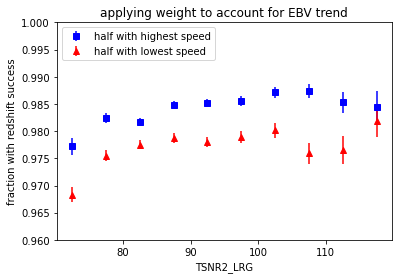

In [44]:
#split on speed again, but account expectation just from EBV
speedc = speed > mds
ntot,tb = np.histogram(fl[speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt),weights=ewl[speedc&gz])
nl,_ = np.histogram(fl[~speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt),weights=ewl[~speedc&gz])
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest speed')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest speed')
em = erf((bl-17.2)/31.7)*.979
#plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.96,1.0)
plt.title('applying weight to account for EBV trend')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction with redshift success')
plt.show()

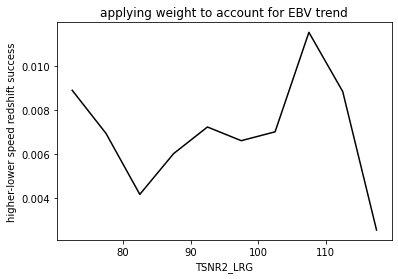

In [22]:
plt.plot(bl,ng/ntot-ngl/nl,'k-')
plt.xlabel('TSNR2_LRG')
plt.ylabel('higher-lower speed redshift success')
plt.title('applying weight to account for EBV trend')
plt.show()

In [156]:
def zsuccessvs(par,wts=None,title='',sel=None,rgfac=.03):
    if wts is None:
        wts = np.ones(len(fl))
    if sel is None:
        sel = np.ones(len(fl),dtype='bool')
    selht = fl['TSNR2_LRG'] > 85
    selht &= sel
    ntot,tb = np.histogram(fl[selht][par],bins=10,range=(np.percentile(fl[selht][par],1),np.percentile(fl[selht][par],99)))
    #gz = fl['ZWARN'] == 0
    gz = wz
    ng,_ = np.histogram(fl[selht&gz][par],bins=tb,weights=wts[selht&gz])
    step = tb[1]-tb[0]
    bl = tb[:-1]+step/2.
    dl = ng/ntot
    varl = dl*ntot*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/ntot#/fr
    plt.errorbar(bl,ng/ntot,el,fmt='ko')
    mn = sum(ng)/sum(ntot)
    plt.plot(bl,np.ones(len(ng))*mn,'k:')
    plt.ylabel('redshift success rate')
    plt.xlabel(par)
    plt.ylim(mn-rgfac,mn+rgfac)
    plt.title(title)
    plt.show()
    
    return bl,ng/ntot,el


In [33]:
fl['speed'] = speed

In [131]:
pars = ['SEEING_ETC',
 'AIRMASS',
 'TRANSPARENCY_GFA',
 'SEEING_GFA',
 'SKY_MAG_AB_GFA',
 'SKY_MAG_G_SPEC',
 'SKY_MAG_R_SPEC',
 'SKY_MAG_Z_SPEC','speed','EBV']

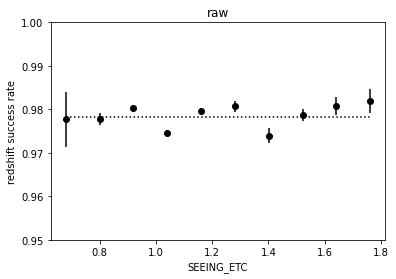

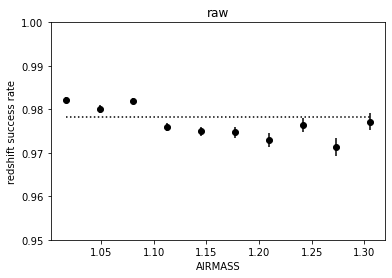

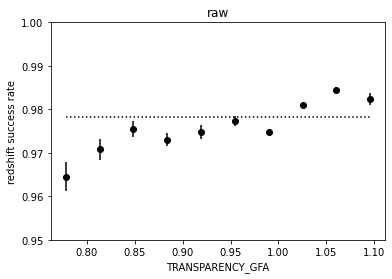

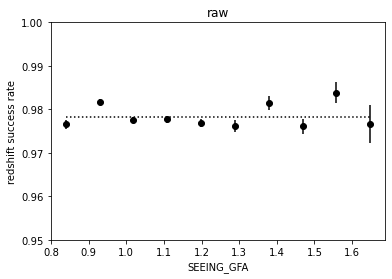

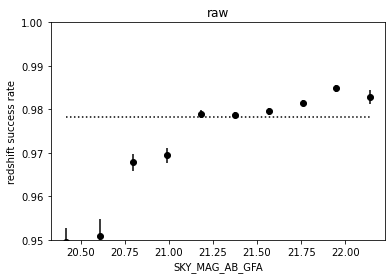

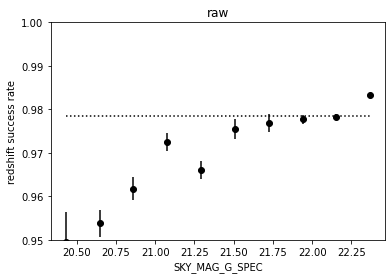

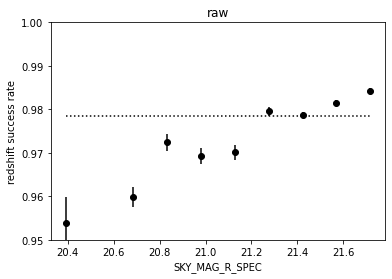

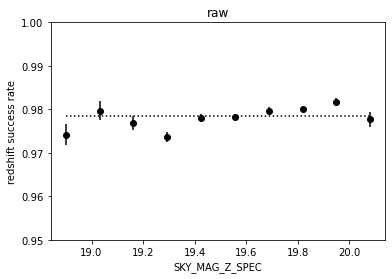

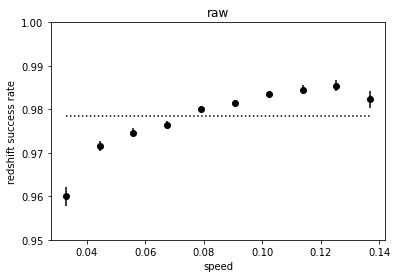

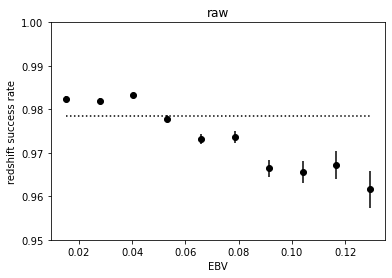

In [146]:
for par in pars:
    zsuccessvs(par,title='raw' )

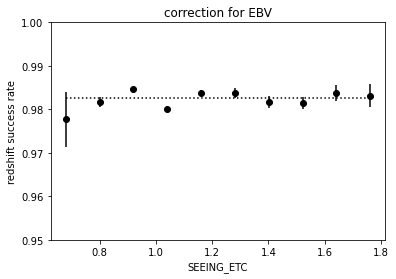

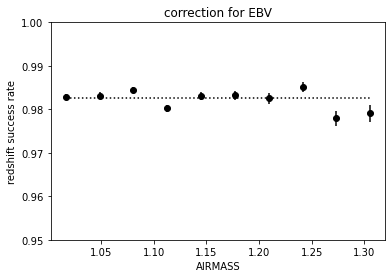

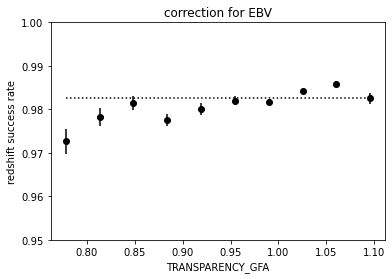

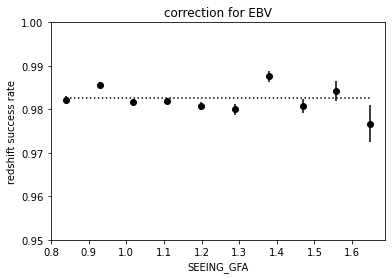

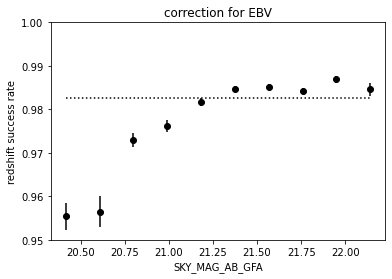

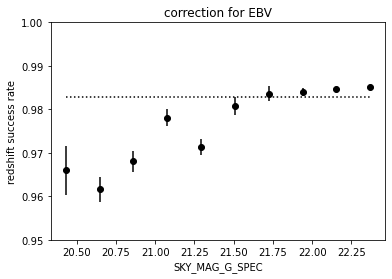

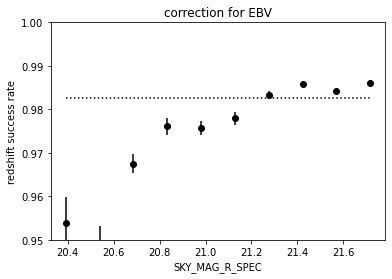

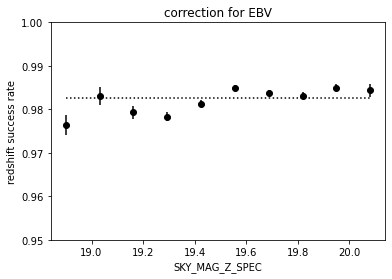

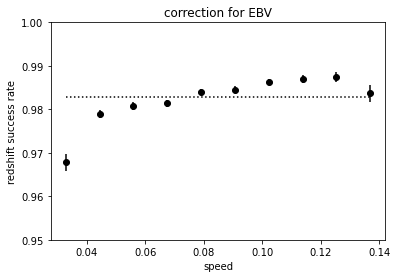

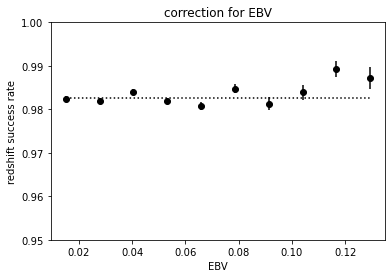

In [147]:
for par in pars:
    zsuccessvs(par,ewl,title='correction for EBV' )

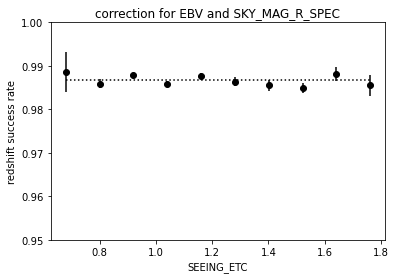

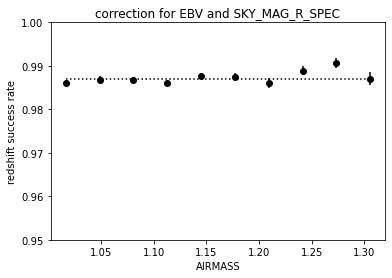

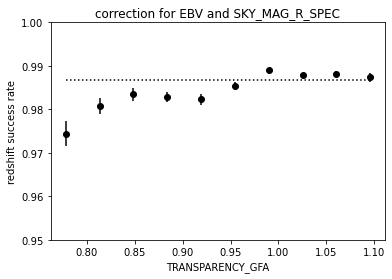

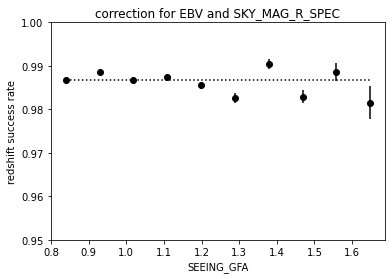

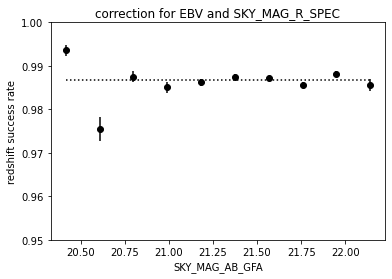

<ipython-input-144-657d5bf83eb6>:15: RuntimeWarning: invalid value encountered in sqrt
  el = np.sqrt(varl)/ntot#/fr


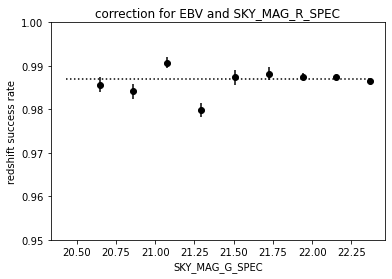

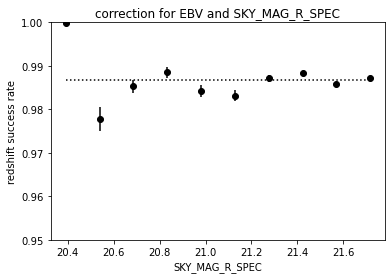

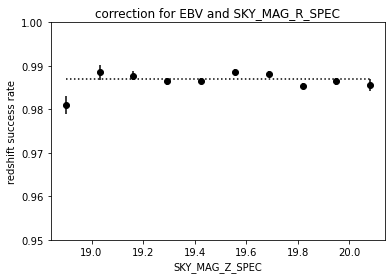

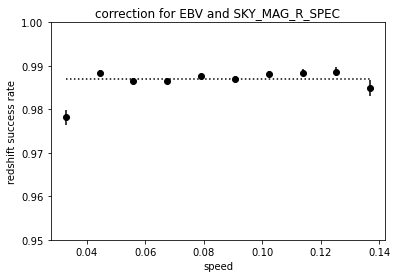

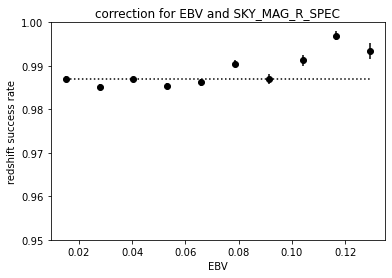

In [145]:
for par in pars:
    zsuccessvs(par,ewl*wtsb,'correction for EBV and SKY_MAG_R_SPEC' )

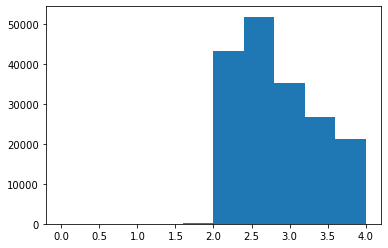

In [125]:
plt.hist(fl['FIBERFLUX_Z'],range=(0,4))
plt.show()

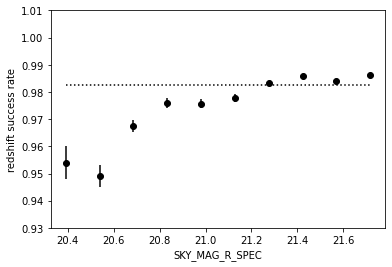

In [135]:
bl,vl,el = zsuccessvs('SKY_MAG_R_SPEC',ewl)

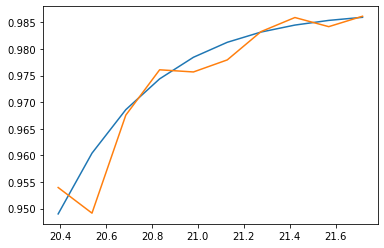

In [136]:
mod = .987 - 20.*(1-erf((bl-16)/2))
plt.plot(bl,mod)
plt.plot(bl,vl)
plt.show()

In [125]:
modsb = .987 - 20.*(1-erf((fl['SKY_MAG_R_SPEC']-16)/2))
wtsb = .987/modsb

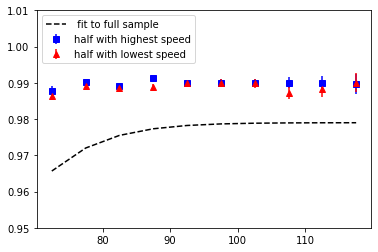

In [150]:
#split on speed again, but account expectation just from EBV
fc = fl['FIBERFLUX_Z'] > 3
speedc = speed > mds
ntot,tb = np.histogram(fl[fc&speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[fc&speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nl,_ = np.histogram(fl[~speedc&fc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz&fc]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest speed')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest speed')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.95,1.01)
#plt.title('applying weight to account for EBV trend')
plt.show()

In [130]:
len(fl[fc]),len(fl)

(226530, 340944)

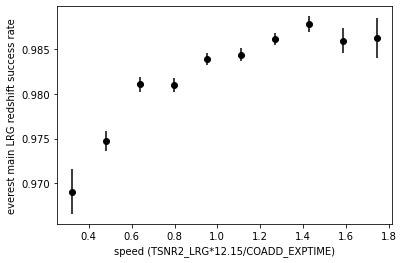

In [151]:
selht = fl['TSNR2_LRG'] > 85
ntot,tb = np.histogram(speed[selht],bins=10,range=(0.02,0.15))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(speed[selht&gz],bins=tb,weights=ewl[selht&gz])
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
modl = np.zeros(len(bl))
for ii in range(0,len(bl)):
    modl[ii] = ebvmod(bl[ii])
plt.errorbar(bl*12.15,ng/ntot,el,fmt='ko')
#plt.plot(bl,modl,'k-')
plt.ylabel('everest main LRG redshift success rate')
plt.xlabel('speed (TSNR2_LRG*12.15/COADD_EXPTIME)')
plt.show()


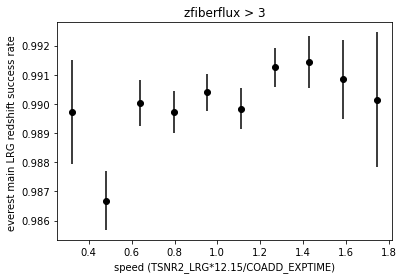

In [152]:
selht = fl['TSNR2_LRG'] > 85
ntot,tb = np.histogram(speed[selht&fc],bins=10,range=(0.02,0.15))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(speed[selht&gz&fc],bins=tb)
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
modl = np.zeros(len(bl))
for ii in range(0,len(bl)):
    modl[ii] = ebvmod(bl[ii])
plt.errorbar(bl*12.15,ng/ntot,el,fmt='ko')
#plt.plot(bl,modl,'k-')
plt.ylabel('everest main LRG redshift success rate ')
plt.xlabel('speed (TSNR2_LRG*12.15/COADD_EXPTIME)')
plt.title('zfiberflux > 3')
plt.show()


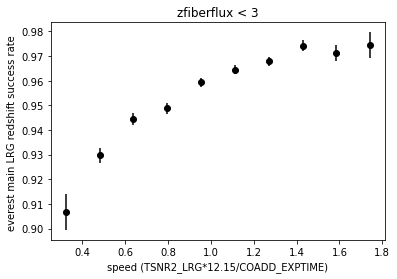

In [153]:
selht = fl['TSNR2_LRG'] > 85
#selht &= fl['COADD_NUMNIGHT'] == 1
ntot,tb = np.histogram(speed[selht&~fc],bins=10,range=(0.02,0.15))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(speed[selht&gz&~fc],bins=tb)
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
modl = np.zeros(len(bl))
for ii in range(0,len(bl)):
    modl[ii] = ebvmod(bl[ii])
plt.errorbar(bl*12.15,ng/ntot,el,fmt='ko')
#plt.plot(bl,modl,'k-')
plt.ylabel('everest main LRG redshift success rate ')
plt.xlabel('speed (TSNR2_LRG*12.15/COADD_EXPTIME)')
plt.title('zfiberflux < 3')
plt.show()


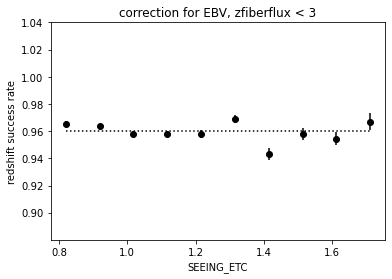

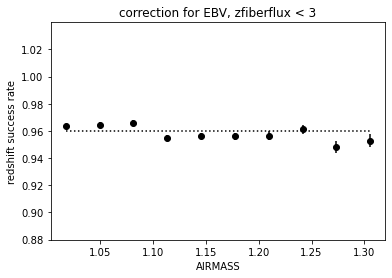

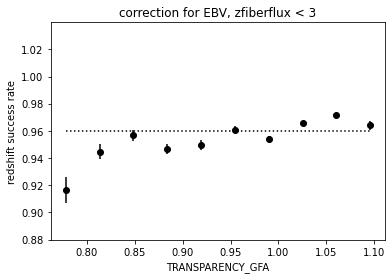

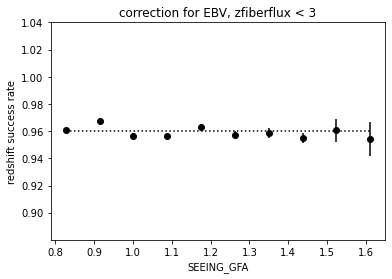

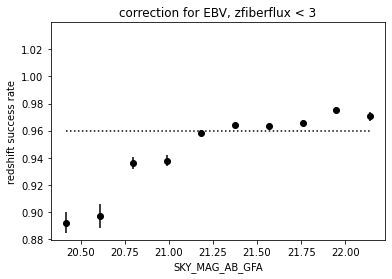

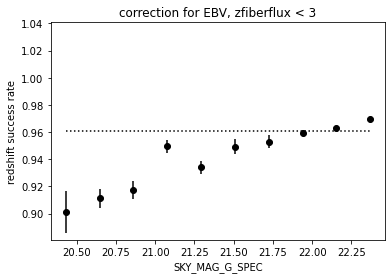

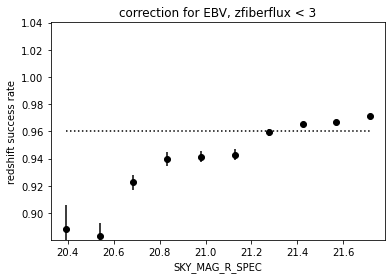

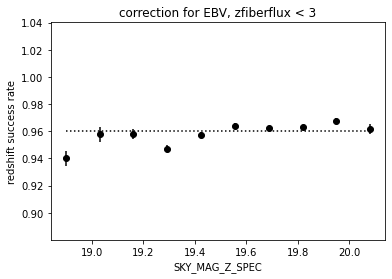

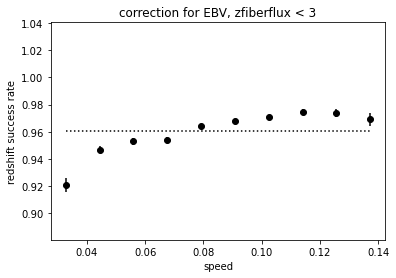

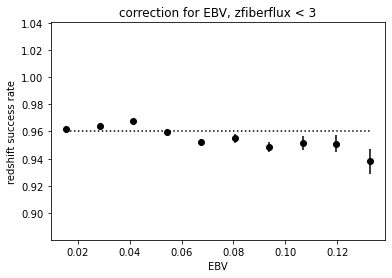

In [159]:
for par in pars:
    zsuccessvs(par,ewl,title='correction for EBV, zfiberflux < 3',sel=~fc,rgfac=.08 )

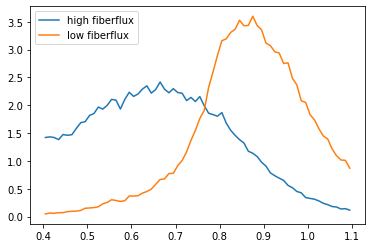

In [142]:
nzh,zb = np.histogram(fl[fc&wz]['Z'],bins=70,range=(0.4,1.1),density=True)
nzl,_ = np.histogram(fl[~fc&wz]['Z'],bins=70,range=(0.4,1.1),density=True)
stepz =zb[1]-zb[0]
zl = zb[:-1]+stepz/2.
plt.plot(zl,nzh,label='high fiberflux')
plt.plot(zl,nzl,label='low fiberflux')
plt.legend()
plt.show()


In [143]:
speedm = speed*12.15

In [144]:
np.min(speedm)

0.10386134

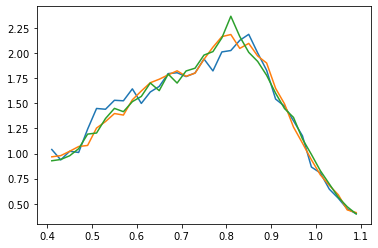

In [187]:
sb = np.percentile(speedm,[0.1,20,50,99])
for ii in range(0,len(sb)-1):
    ms = sb[ii]
    xs = sb[ii+1]
    speedc = speedm > ms
    speedc &= speedm < xs
    nzh,zb = np.histogram(fl[speedc&wz]['Z'],bins=35,range=(0.4,1.1),density=True)
    stepz =zb[1]-zb[0]
    zl = zb[:-1]+stepz/2.
    plt.plot(zl,nzh,label=str(ms)+'<speed<'+str(xs))
#plt.legend()
plt.show()

(array([276108.,      0.,      0.,  50862.,      0.,      0.,  12707.,
             0.,      0.,   1267.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

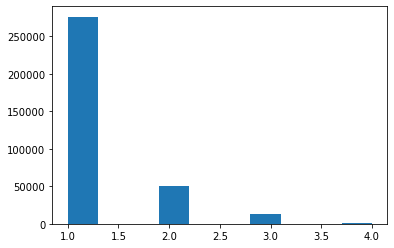

In [156]:
plt.hist(fl['COADD_NUMEXP'])

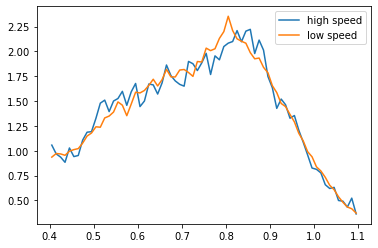

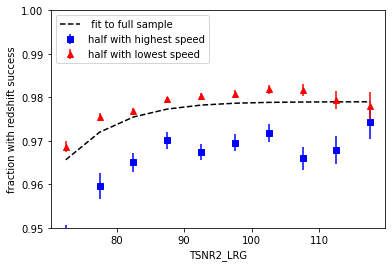

In [157]:
#split on speed
speedc = fl['COADD_NUMEXP'] > 1
ntot,tb = np.histogram(fl[speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzh,zb = np.histogram(fl[speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
nl,_ = np.histogram(fl[~speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzl,_ = np.histogram(fl[~speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
stepz =zb[1]-zb[0]
zl = zb[:-1]+stepz/2.
plt.plot(zl,nzh,label='high speed')
plt.plot(zl,nzl,label='low speed')
plt.legend()
plt.show()
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest speed')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest speed')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.95,1.0)
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction with redshift success')
plt.show()

In [162]:
sel1e = fl['COADD_NUMEXP'] == 1

In [164]:
len(fl[sel1e])/len(fl)

0.8098338730114036

In [165]:
np.percentile(speed,.81)

0.02549931680429727

(array([1.0000e+00, 4.0000e+02, 6.6080e+03, 1.5524e+04, 3.0204e+04,
        3.6710e+04, 4.6101e+04, 5.1061e+04, 4.6749e+04, 4.1075e+04,
        3.0284e+04, 1.8873e+04, 1.0268e+04, 4.4400e+03, 1.7790e+03,
        6.3300e+02, 1.4800e+02, 1.2000e+01, 2.0000e+00, 1.0000e+00]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ],
       dtype=float32),
 <a list of 20 Patch objects>)

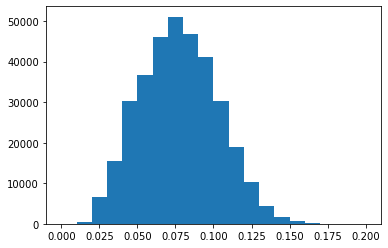

In [168]:
plt.hist(speed,bins=20,range=(0,.2))

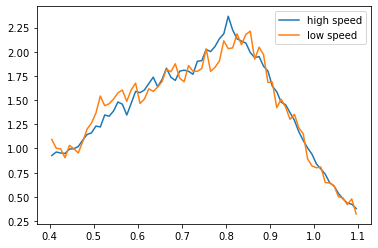

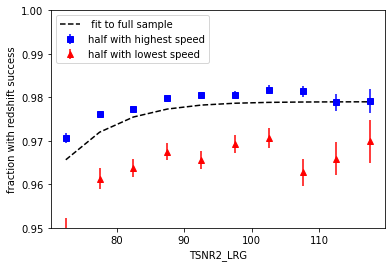

In [178]:
#split on speed
speedc = speed > np.percentile(speed,19)
ntot,tb = np.histogram(fl[speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
#gz = fl['ZWARN'] == 0
gz = wz
ng,_ = np.histogram(fl[speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzh,zb = np.histogram(fl[speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
nl,_ = np.histogram(fl[~speedc]['TSNR2_LRG'],bins=10,range=(mint,maxt))
ngl,_ = np.histogram(fl[~speedc&gz]['TSNR2_LRG'],bins=tb,range=(mint,maxt))
nzl,_ = np.histogram(fl[~speedc&gz]['Z'],bins=70,range=(0.4,1.1),density=True)
stepz =zb[1]-zb[0]
zl = zb[:-1]+stepz/2.
plt.plot(zl,nzh,label='high speed')
plt.plot(zl,nzl,label='low speed')
plt.legend()
plt.show()
step = tb[1]-tb[0]
bl = tb[:-1]+step/2.
dl = ng/ntot
varl = dl*ntot*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/ntot#/fr
dll = ngl/nl
varl = dll*nl*(1.-dll) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
ell = np.sqrt(varl)/nl#/fr

plt.errorbar(bl,ng/ntot,el,fmt='bs',label='half with highest speed')
plt.errorbar(bl,ngl/nl,ell,fmt='r^',label='half with lowest speed')
em = erf((bl-17.2)/31.7)*.979
plt.plot(bl,em,'k--',label=' fit to full sample')
#em3 = erf((bl-13.2)/39.7)*.9855
#plt.plot(bl,em3,'k:',label='SV3 fit (full sample)')
plt.legend(loc='upper left')
plt.ylim(.95,1.0)
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction with redshift success')
plt.show()

In [177]:
np.percentile(speed,19)

0.05353712242096663

In [172]:
np.min(speed)

0.008548259

In [184]:
len(speed[~speedc])

170813

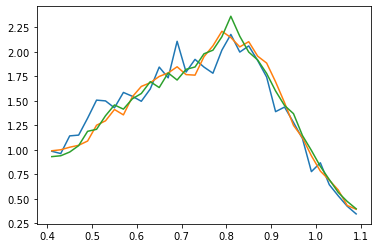

In [186]:
sel1 = fl['COADD_NUMEXP'] == 1
sb = np.percentile(speedm,[0.1,20,50,99.9])
for ii in range(0,len(sb)-1):
    ms = sb[ii]
    xs = sb[ii+1]
    speedc = speedm > ms
    speedc &= speedm < xs
    nzh,zb = np.histogram(fl[sel1&speedc&wz]['Z'],bins=35,range=(0.4,1.1),density=True)
    stepz =zb[1]-zb[0]
    zl = zb[:-1]+stepz/2.
    plt.plot(zl,nzh,label=str(ms)+'<speed<'+str(xs))
#plt.legend()
plt.show()

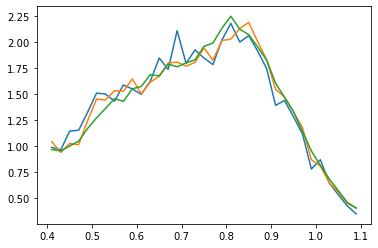

In [190]:
sel1 = fl['COADD_NUMEXP'] == 1
sb = np.percentile(speedm,[0.1,20,50,99.9])
#for ii in range(0,len(sb)-1):
ms = sb[0]
xs = sb[1]
speedc = speedm > ms
speedc &= speedm < xs
nzh,zb = np.histogram(fl[sel1&speedc&wz]['Z'],bins=35,range=(0.4,1.1),density=True)
nzl,_ = np.histogram(fl[speedc&wz]['Z'],bins=35,range=(0.4,1.1),density=True)
nza,_ = np.histogram(fl[wz]['Z'],bins=35,range=(0.4,1.1),density=True)

stepz =zb[1]-zb[0]
zl = zb[:-1]+stepz/2.
plt.plot(zl,nzh,label='20th percentile & numexp=1')
plt.plot(zl,nzl,label='20th percentile')
plt.plot(zl,nza,label='all')
#plt.legend()
plt.show()